In [0]:
import os
import sys
import warnings
import numpy

def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.simplefilter(action='ignore', category=FutureWarning)
numpy.seterr(divide = 'ignore') 

sys.path.append(os.path.dirname(os.path.abspath('')))

In [2]:
pip install git+https://github.com/notadamking/tensortrade.git

  Cloning https://github.com/notadamking/tensortrade.git to /tmp/pip-req-build-iej0g4iu
  Running command git clone -q https://github.com/notadamking/tensortrade.git /tmp/pip-req-build-iej0g4iu
  Created wheel for tensortrade: filename=tensortrade-0.1.0rc1-cp36-none-any.whl size=65872 sha256=9fff7c5082e08247f2322919a21f77dfe92bbb1f14cfc4ad2fe09017c972050d
  Stored in directory: /tmp/pip-ephem-wheel-cache-4s86vxkj/wheels/e6/47/d1/28241d46a9a2df2f3a6cf4f882a1a66337cade30c68579f6f1
Successfully built tensortrade


In [3]:
pip install git+https://github.com/notadamking/tensortrade.git#egg=tensortrade[tf,tensorforce,baselines,ccxt,ta,fbm] -U

  Cloning https://github.com/notadamking/tensortrade.git to /tmp/pip-install-ig53g3gy/tensortrade
  Running command git clone -q https://github.com/notadamking/tensortrade.git /tmp/pip-install-ig53g3gy/tensortrade
     |████████████████████████████████| 225kB 9.5MB/s 
     |████████████████████████████████| 1.4MB 65.7MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 317kB 44.1MB/s 
     |████████████████████████████████| 92.5MB 103kB/s 
     |████████████████████████████████| 2.3MB 40.7MB/s 
     |████████████████████████████████| 1.2MB 50.5MB/s 
     |████████████████████████████████| 256kB 56.8MB/s 
     |████████████████████████████████| 3.2MB 47.1MB/s 
     |████████████████████████████████| 368kB 54.9MB/s 
     |████████████████████████████████| 358kB 51.9MB/s 
     |████████████████████████████████| 204kB 29.9MB/s 
  Created wheel for tensortrade: filename=tensortrade-0.1.0rc1-cp36-none-any.whl size=65872 sha256=70ac6da0a535ae545f

In [0]:
import pandas as pd
url = 'https://raw.githubusercontent.com/KU-BIG/2019_Autumn_Algorithm_Trading/master/data/stock/071840.csv'
df = pd.read_csv(url)
#df = pd.read_csv(url, usecols = ['High','Low','Open', 'Close','Volume'])

df.columns = ['Datetime', 'High', 'Low', 'Open', 'Close','Volume', 'Adj Close']


In [5]:
df.head()

,Datetime,High,Low,Open,Close,Volume,Adj Close
0,20110629,58700,50300,53100,57000,2292207,NaN
1,20110630,56600,52200,56000,54800,740039,NaN
2,20110701,57400,53700,54800,57000,484983,NaN
3,20110704,57700,55800,57000,55800,154045,NaN
4,20110705,55500,53500,55300,54000,396287,NaN


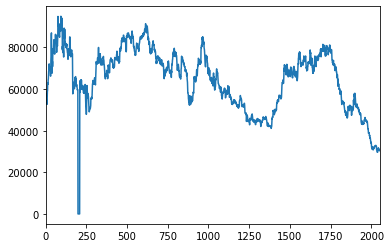

In [6]:
import matplotlib
%matplotlib inline

df.High.plot()

In [0]:
df = df.drop('Adj Close', axis=1)

In [8]:
df.head()

,Datetime,High,Low,Open,Close,Volume
0,20110629,58700,50300,53100,57000,2292207
1,20110630,56600,52200,56000,54800,740039
2,20110701,57400,53700,54800,57000,484983
3,20110704,57700,55800,57000,55800,154045
4,20110705,55500,53500,55300,54000,396287


In [9]:
#exchange
from tensortrade.exchanges.simulated import FBMExchange
import pandas as pd
from tensortrade.exchanges.simulated import SimulatedExchange

#feature pipeline 
from tensortrade.features.scalers import MinMaxNormalizer
from tensortrade.features.stationarity import FractionalDifference
from tensortrade.features import FeaturePipeline

# rewards scheme
from tensortrade.rewards import SimpleProfit

# action scheme
from tensortrade.actions import DiscreteActions

# environments
from tensortrade.environments import TradingEnvironment

normalize_price = MinMaxNormalizer(["open", "high", "low", "close"])
difference = FractionalDifference(difference_order=0.6)
feature_pipeline = FeaturePipeline(steps=[normalize_price, 
                                          difference])

url = 'https://raw.githubusercontent.com/KU-BIG/2019_Autumn_Algorithm_Trading/master/data/stock/071840.csv'  #하이마트 종목코드
df = pd.read_csv(url)
#df = pd.read_csv(url, usecols = ['High','Low','Open', 'Close','Volume'])
df.columns = ['Datetime', 'high', 'low', 'open', 'close','volume', 'Adj Close']
df = df.drop('Adj Close', axis=1)

exchange = SimulatedExchange(data_frame=df, base_instrument='KRW', pretransform=True)
exchange.feature_pipeline = feature_pipeline

reward_scheme = SimpleProfit()  #변형해야 할 필요가 있다. (reward가 좀 이상함.)

action_scheme = DiscreteActions(n_actions = 20,
                                instrument = 'KRW')

environment = TradingEnvironment(exchange=exchange,
                                 feature_pipeline=feature_pipeline,
                                 action_scheme=action_scheme,
                                 reward_scheme=reward_scheme)

In [0]:
from stable_baselines.common.policies import MlpLnLstmPolicy, CnnLstmPolicy
from stable_baselines import PPO2, A2C

model = PPO2
policy = MlpLnLstmPolicy
params = {"learning_rate": 1e-5, "nminibatches" : 1 }

In [0]:
from tensortrade.strategies import StableBaselinesTradingStrategy

strategy = StableBaselinesTradingStrategy(environment=environment,
                                          model=model,
                                          policy=policy,
                                          model_kwargs=params)

In [12]:
performance = strategy.run(steps=100000)
#performance = strategy.run(steps=10000, episode_callback=early_episode_callback)

Finished running strategy.
Total episodes: 48 (100000 timesteps).
Average reward: -1.0405379857066457.


In [13]:
performance.head()

,step,balance,net_worth
0,1.0,7520.707476,9971.202364
1,2.0,8155.291367,10066.945397
2,3.0,8621.740120,10025.296492
3,4.0,8955.432572,9974.142572
4,5.0,9950.432906,9950.432906


In [14]:
performance.tail()

,step,balance,net_worth
1403,1404.0,933.003749,1053.621933
1404,1405.0,933.003749,1055.666309
1405,1406.0,474.367651,1055.572251
1406,1407.0,615.840367,1049.946277
1407,1408.0,615.840367,1062.529057


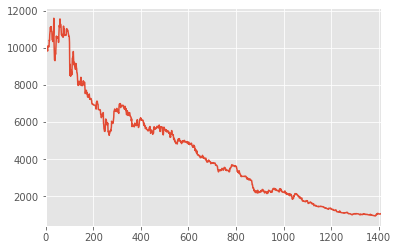

In [15]:
%matplotlib inline
performance.net_worth.plot()

1. 일 단위 데이터는 강화학습에는 적합하지 않다.(시간데이터 필요)    
2. feature_pipeline 수정이 필요하다.
3. difference_order의 역할??
4. 원 -> 달러 계산 때문에? 
5. parameter tuning 때문에???(ex. PPO2, nminibatches, policy, reward, action space (discrete) 조정 등이 필요할 듯) 
A2C -> parameter
6. 100000 돌려보기. ?? 다소 나아지는 양상을 보이긴 한다. 

=> 강화학습은 modulation이 심해서 주식 거래에서 수익을 내기가 쉽지 않다. 
=> 그래프 많이 변화하는 것 캡쳐 및 최종발표 준비. 
=> 

In [0]:
from google.colab import drive

drive.mount('/content/drive')

In [0]:
strategy.save_agent(path="/content/drive/My Drive/ppo_btc_1h")

In [0]:
strategy = StableBaselinesTradingStrategy(environment=environment,
                                          model=model,
                                          policy=policy,
                                          model_kwargs=params)

strategy.restore_agent(path="/content/drive/My Drive/ppo_btc_1h")